Aiming to reacreate the VGG 19 network. <br>
Input is 10,3,224,224 dims in the order B,C,W,H <br>
Preprocessing of images was done by subtracting the mean RGB value, computed on the training set, from each pixel. <BR>

[Architecture](https://gist.github.com/ksimonyan/211839e770f7b538e2d8#file-readme-md) <br>

In [26]:
import os
import torch
from torch import nn,optim
from torch.utils.data import Dataset,DataLoader
from torchvision import io
from torchvision import transforms
import pandas as pd
import tqdm
import csv
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torchmetrics
import zipfile
import shutil
import pathlib

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Prepare and load the dataset

## Data Preparation

In [30]:
# unzip the file
with zipfile.ZipFile("./data/caltech256.zip","r") as zip:
    zip.extractall("./data/caltech256/")
shutil.rmtree("./data/caltech256/256_objectcategories/")
shutil.move("./data/caltech256/256_ObjectCategories/","./data/caltech256/train/")
os.mkdir("./data/caltech256/test/")

In [31]:
# train/test split
for a,_,files in os.walk("./data/caltech256/train/"):
    for f in files[:5]:
        if not os.path.exists("./data/caltech256/test/"+os.path.basename(a)+"/"):
            os.mkdir("./data/caltech256/test/"+os.path.basename(a)+"/") 
        os.rename(a+"/"+f,"./data/caltech256/test/"+os.path.basename(a)+"/"+f)

In [11]:
# train/test labels
train_labels = []
test_labels = []
categories = {}
for dirpath,_,files in os.walk("./train/"):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label = int(os.path.basename(dirpath).split(".")[0])-1
            label_name = os.path.basename(dirpath).split(".")[1]
            categories[label] = label_name
            train_labels.append([path,label])

if not os.path.exists('./train_labels.csv'):
  with open('./train_labels.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(train_labels)


for dirpath,_,files in os.walk("./test/"):
    if len(files)>0:
        for f in files:
            path = dirpath+"/"+f
            label = int(os.path.basename(dirpath).split(".")[0])-1
            test_labels.append([path,label])

if not os.path.exists('./test_labels.csv'):
  with open('./test_labels.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerows(test_labels)
  
categories

## Datasets and Dataloaders

In [21]:
class ImageDatasetCustom(Dataset):
    def __init__(self,image_labels,transform=None,target_transform=None):
        self.image_labels = pd.read_csv(image_labels)
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.image_labels)
    
    def __getitem__(self, idx):
        try:
            image = io.read_image(self.image_labels.iloc[idx, 0]).type(torch.float32)
            label = self.image_labels.iloc[idx, 1]
            if image.shape[0] == 1:
                image = torch.cat((image,image,image),dim=0)
            # print(image.shape)
            if self.transform:
                image = self.transform(image)
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        except Exception as e:
            print(f"Dataset error: {str(e)}, image: {self.image_labels.iloc[idx, 0]}")

train_dataset = ImageDatasetCustom("./data/caltech256/train_labels.csv",
                                    transform=transforms.transforms.Resize((224,224),antialias=True))
                                
test_dataset = ImageDatasetCustom("./data/caltech256/test_labels.csv",
                                  transform=transforms.Resize((224,224),antialias=True))

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

Feature batch shape: torch.Size([10, 3, 224, 224])
Labels batch shape: torch.Size([10])
(224, 224, 3)
cake


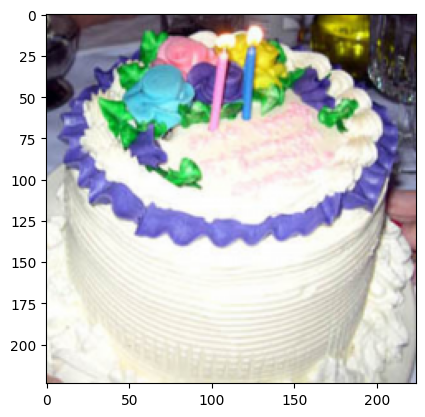

In [20]:
# Explore the dataset

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = np.transpose(train_features[0].type(torch.int).numpy(), (1, 2, 0))
print(image.shape)

print(categories[train_labels[0].item()])
plt.imshow(image)
plt.show()

# Build the VGG 19 model

In [22]:
class VGGCNN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,out_channels=64,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,out_channels=128,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),

            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=(3,3),stride=(1,1),padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=(2,2)),
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Sequential(
            nn.Linear(in_features=25088,out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(in_features=4096,out_features=257),
        )
    
    def forward(self,X):
        return self.fc(self.flatten(self.cnn(X)))

model = VGGCNN().to(device)

# Train the model

In [ ]:
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)
loss_fn = nn.CrossEntropyLoss()
accuracy_fn = torchmetrics.Accuracy(task="multiclass", num_classes=257).to(device)
EPOCHS = 10

epoch_counts = []
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

for epoch in tqdm.tqdm(range(EPOCHS)):
    print(f"\n Epoch {epoch}\n----------------------------------")
    epoch_counts.append(epoch)

    # train
    train_loss,train_acc = 0,0
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X = X.to(device)
        y = y.to(device)
        train_logits = model(X)
        y_pred = torch.softmax(train_logits,dim=1).argmax(dim=1)
        training_loss = loss_fn(train_logits,y)
        train_acc += accuracy_fn(y_pred,y) * 100
        train_loss += training_loss.item()
        optimizer.zero_grad()
        training_loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    training_losses.append(train_loss)
    training_accuracies.append(train_acc)

    #test
    model.eval()
    test_loss, test_acc = 0, 0 
    with torch.inference_mode():
        for batch,(X,y) in enumerate(test_dataloader):
            X = X.to(device)
            y = y.to(device)
            test_logits = model(X)
            test_loss += loss_fn(test_logits,y).item()
            y_test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            test_acc += accuracy_fn(y_test_pred,y).item() * 100
    
    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    testing_losses.append(test_loss)
    testing_accuracies.append(test_acc * 100)

    print(f"\nTrain loss: {train_loss:.6f}, Train acc:{train_acc:.5f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

In [23]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 536.435MB


In [25]:
!mkdir models
MODEL_PATH = pathlib.Path("models/vgg19.pt")

torch.save(model.state_dict(),MODEL_PATH)

mkdir: cannot create directory ‘models’: File exists


NameError: name 'pathlib' is not defined